In [322]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool

import reddemcee


rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
%matplotlib widget


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [321]:
%matplotlib inline


# Data

## La10d

In [ ]:
e3_La10d = pd.read_csv("ETP/La10d.dat", delimiter="|")
e3_La10d = e3_La10d[["t","e"]].to_numpy().T
e3_La10d[0] = -e3_La10d[0]

In [ ]:
t0, tf = 0, 5e3
inds = (e3_La10d[0]>=t0) & (e3_La10d[0]<=tf)
times, y_model = e3_La10d[:, inds]
y_model = (y_model-y_model.mean())/y_model.std()
# y = y + noise

In [ ]:
N_data = len(y_model)
sigma_true = 0.7
rho_true = 0.9

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

y = y_model + noise

In [ ]:
%matplotlib inline
plt.plot(times, y)
plt.plot(times, y_model)

## ETP

In [ ]:
ecc = pd.read_csv("ETP/eccentricity.csv")
prec = pd.read_csv("ETP/precession.csv")
obl = pd.read_csv("ETP/obliquity.csv")

ETP = np.zeros((4, 10001))
ETP[0] = ecc["x"]
ETP[1] = ecc["y"]
ETP[2] = obl["y"]
ETP[3] = prec["y"]

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,3), constrained_layout=True)
axs[0].plot(ETP[0], ETP[1])
axs[1].plot(ETP[0], ETP[2])
axs[2].plot(ETP[0], ETP[3])

In [ ]:
i_t0 = 0; i_tf = 3000
times = ETP[0,i_t0:i_tf]
alpha = 0.5
y_model = ETP[1,i_t0:i_tf]*1+ ETP[3,i_t0:i_tf]*1
N_data = len(y_model)
sigma_true = 1.4
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

y = y_model + noise

In [ ]:
plt.figure()
plt.plot(times, y)
plt.plot(times, y_model)


# Model

In [ ]:
coef_time = 1e3


b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
g_k = muy_k[ordering]
phi_k = phi_k[ordering]


# fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
# fe_k = fe_k/180/3600*np.pi*coef_time

fe_k =  np.array([g_k[1]-g_k[4], g_k[3]-g_k[4] , g_k[3]-g_k[1], g_k[2]-g_k[4], g_k[2]-g_k[1], g_k[3]-g_k[2], g_k[0]-g_k[4]])

fs = np.hstack([g_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

In [ ]:
g_k[3]-g_k[2], g_k

## When time is known

In [ ]:
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(fe_k), fe_k, times)
X = generate_X_linReg(np.ones_like(fs), fs, times)

# reg.fit(X, y)
reg.fit(X, y_model)

y_pred = reg.predict(X)
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(times, y)
plt.plot(times, y_model, "--", color="black")
plt.plot(times, y_pred, color="red")
print(r2_score(y_model, y_pred), r2_score(y, y_pred))
# plt.xlim([2500,3000])

In [ ]:
i_t0 = 0; i_tf = 10000
N_data = len(ETP[0])
sigma_true = 1*np.sqrt(2)
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

# y = y_model + noise

In [ ]:
i_t0 = 0
# i_tfs = np.array([1000*i for i in range(1,11) ])
i_tfs = np.arange(1000, 10001, 100)
r2s = np.zeros_like(i_tfs, dtype=float)
r2s_noise = np.zeros_like(i_tfs, dtype=float)

for i, i_tf in enumerate(i_tfs):
    times = ETP[0,i_t0:i_tf]
    y_model = ETP[1,i_t0:i_tf]*1+ ETP[3,i_t0:i_tf]*0
    X = generate_X_linReg(np.ones_like(fs), fs, times)
    X = generate_X_linReg(np.ones_like(fe_k[:]), fe_k[:], times)
    reg = linear_model.LinearRegression()

    reg.fit(X, y_model)
    y_pred = reg.predict(X)
    r2s[i] = r2_score(y_model, y_pred)
    
    y = y_model + noise[i_t0:i_tf]
    reg.fit(X, y)
    y_pred = reg.predict(X)
    r2s_noise[i] = r2_score(y_model, y_pred)

In [ ]:
fig  = plt.figure()
plt.plot((i_tfs-i_t0)/1e3, r2s, label="no noise")
plt.plot((i_tfs-i_t0)/1e3, r2s_noise,label="with noise")
plt.title("ETP 1-0-1")
plt.xlabel("Interval length [Myr]")
plt.ylabel("r2")
plt.legend()

In [ ]:
fig  = plt.figure()
plt.plot((i_tfs-i_t0)/1e3, r2s, label="no noise")
plt.plot((i_tfs-i_t0)/1e3, r2s_noise,label="with red noise")
plt.title("ETP 1-0-0")
plt.xlabel("Interval length [Myr]")
plt.ylabel("r2")
plt.legend()

## Age

In [ ]:
i_t0 = 0; i_tf = 3000
times = ETP[0,i_t0:i_tf]
alpha = 0.5
y_model = ETP[1,i_t0:i_tf]*1+ ETP[3,i_t0:i_tf]*1

In [ ]:
%matplotlib inline
y_sp = CubicSpline(times, y_model)

depth = times*1 # 1 cm/1kyr average

func_inv_SR = partial(sine_inverse_SR, A=0.3, k= 4*1e-3)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=2)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
times_true = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

plt.figure(constrained_layout=True,figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(depth, invSR, '.')
plt.subplot(1,2,2)
plt.plot(depth, times_true)

# x = np.linspace(times[0],times[-1],1000000)
# y = sp(x)
# plt.plot(times,y_model,'.')
# plt.plot(x,y)


In [ ]:
y_model = y_sp(times_true)

sigma_true = 0.7*np.sqrt(2)
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

y = y_model + noise

plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()

### Best case sceranio

In [ ]:
reg = linear_model.LinearRegression()
# X = generate_X_linReg(np.ones_like(fe_k), fe_k, times_true)

depth_genes = np.linspace(depth[0], depth[-1], 20)
func_inv_SR(depth_genes)
timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

X = generate_X_linReg(np.ones_like(fs), fs, times_true)
# X = generate_X_linReg(np.ones_like(fs), fs, timesx)

reg.fit(X, y)
# reg.fit(X, y_model)

y_pred = reg.predict(X)
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(times_true, y)
plt.plot(times_true, y_model, "--", color="black")
plt.plot(times_true, y_pred, color="red")
print(r2_score(y_model, y_pred), r2_score(y, y_pred))

# GA

## search for optimal length of genes

In [ ]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 22 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = np.hstack([g_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal, metric_optimal.mean())
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

In [ ]:
algorithm = NSGA2(
    pop_size=200,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 200
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
# N_genes_enemble = np.array([24]*10)
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)

N_trial = 4
N_genes_distinct = np.arange(2, 60, 2)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)


problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

In [ ]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
plt.ylim([0.1, 0.8])
# plt.savefig("r2_Ngenesb.png", dpi=200)

In [ ]:
%matplotlib inline
plt.figure(figsize=(7, 5))
for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<=2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))




fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
i = 34
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
print(len(depth_genes))
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

# fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

# time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
# ax.plot(depth, y )
# ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

## got it

In [ ]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 20 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = np.hstack([g_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)

interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

In [ ]:
algorithm = NSGA2(
    pop_size=200,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 200
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
N_genes_enemble = np.array([20]*64)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)

# N_trial = 4
# N_genes_distinct = np.arange(2, 60, 2)
# N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

# N_ensemble = len(depth_genes_ensemble)


problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=len(problems), verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
ind_sort = np.argsort(opt_max_ensemble[:,-1])
res_ensemble = [res_ensemble[i] for i in  ind_sort]
opt_max_ensemble = opt_max_ensemble[ind_sort]

In [ ]:
opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
ind_sort = np.argsort(opt_max_ensemble[:,-1])
res_ensemble = [res_ensemble[i] for i in  ind_sort]
opt_max_ensemble = opt_max_ensemble[ind_sort]

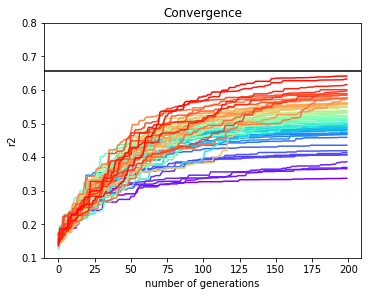

In [345]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(5,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))


metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")


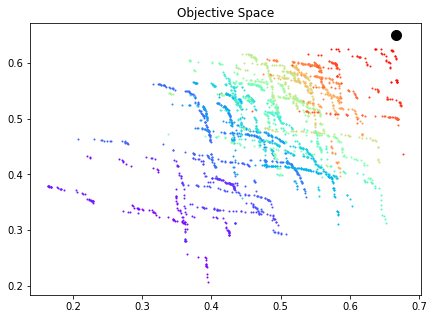

In [344]:
%matplotlib inline
plt.figure(figsize=(7, 5))
metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
plt.scatter(*metric_optimal, s=100, marker='o', color="black")
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


In [ ]:
times_true

[0.66113815 0.6223671 ]
0.6394884389147463


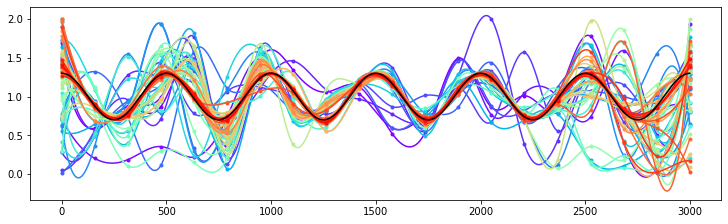

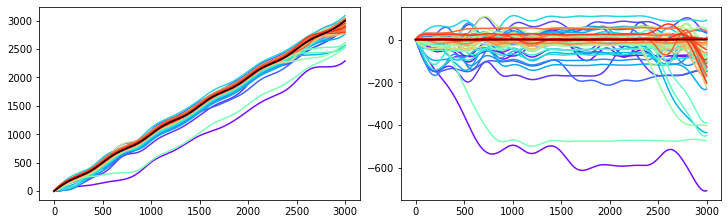

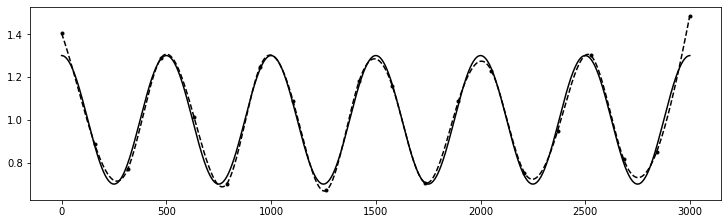

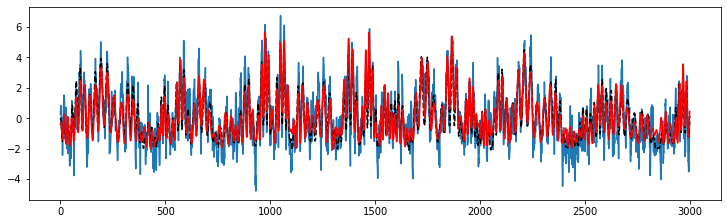

In [343]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-times_true, color=cmap(i/N_ensemble))
axs[0].plot(depth, times_true, color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
# i = -15
i = -1

res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
ax.plot(depth, y )
ax.plot(depth, y_model, "--",color="black")
ax.plot(depth, y_pred, color="red")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

In [354]:
1+1

2

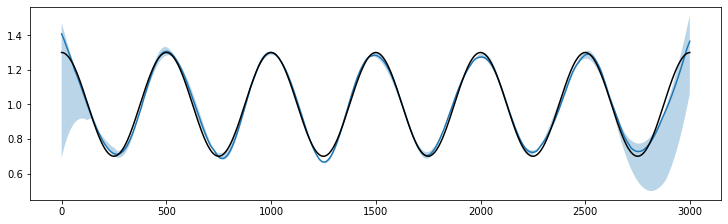

In [360]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
N_indi = 7
# ind_sort = np.argsort(-opt_max_ensemble[:,-1])
# res_ensemblex = [res_ensemble[i] for i in  ind_sort[:10]]
res_ensemblex = res_ensemble[-3:]
invSR_pop = np.zeros([len(depth), len(res_ensemblex), N_indi])
# res_ensemble_x = res_ensemble[10:]
for i, res in enumerate(res_ensemblex):
    # if i<10:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    for j in range(N_indi):
        # arg_best = np.argmin(res.F.sum(axis=1))
        invSR_pop[:, i, j] = interpolator([depth_genes, res.X[j]], depth)
        # ax.plot(depth, interpolator([depth_genes, res.X[j]], depth), color="black",alpha=0.1)
        # ax.plot(depth_genes, res.X[j], '.', alpha=0.1, color="black")
# invSR_pop = invSR_pop[:,40:]
invSR_pop = invSR_pop.reshape(len(depth), -1)
# ax.fill_between(depth, *np.quantile(invSR_pop, [0.25, 0.75], axis=-1), alpha=0.3)
ax.fill_between(depth, *np.quantile(invSR_pop, [0.1, 0.9], axis=-1), alpha=0.3)
ax.plot(depth, np.median(invSR_pop,axis=-1))

ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)


# MCMC

In [ ]:
def loglike_wrapper(func, depth_genes):
    def wrap(x, *args, **kwargs):
        result = func([depth_genes, x], *args, **kwargs)
        return result
    return wrap

In [278]:
# %lprun -f log_likelihood_rednoise  log_likelihood_rednoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, noise_params=[sigma_true, rho_true])         

In [279]:
%timeit  log_likelihood_rednoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, noise_params=[sigma_true, rho_true])         

4.9 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [280]:
5*1e-3*10*50

2.5

In [285]:
res = res_ensemble[-1]
N_genes = res.X.shape[1]
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 40
n_temps = 5
# params_noise_ini = [0.7, 0.7]
# params_noise_ini = [0.7]
params_noise_ini = []
ndim = N_genes+len(params_noise_ini)
params_ini = np.hstack([params_noise_ini, invSR_best])
pos = params_ini + 1e-4 * np.random.randn(n_temps, nwalkers, N_genes+len(params_noise_ini))
pos = list(pos)
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)
params_best = np.hstack([sigma_true, rho_true, func_inv_SR(depth_genes)])

# nwalkers, ndim = pos.shape
# log_posterior = log_posterior_whitenoise
# log_posterior = log_posterior_rednoise_v1
# log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims) 
# log_posterior = log_posterior_whitenoise_v0
# log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims, sigma=0.7) 

logl = partial(log_likelihood_rednoise,  data=[depth, y], fs=fs, noise_params=[sigma_true, rho_true], interpolator=interpolate_CubicSpline) 
# logl = partial(log_likelihood_whitenoise,  data=[depth, y], fs=fs, sigma=sigma_true, interpolator=interpolate_CubicSpline) 

logl([depth_genes, func_inv_SR(depth_genes)])
logl = loglike_wrapper(logl, depth_genes)
# lp(func_inv_SR(depth_genes))
logp = partial(log_uniform, x_lims=invSR_lims)

# with Pool(processes=1) as pool:
with Pool(processes=1) as pool:
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler = reddemcee.PTSampler(nwalkers, ndim, logl, logp)
    sampler.run_mcmc(pos, 1000, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))

In [294]:
samples = np.array([ptsampler.get_chain() for ptsampler in sampler.sampler ])
samples.shape

(5, 1000, 40, 20)

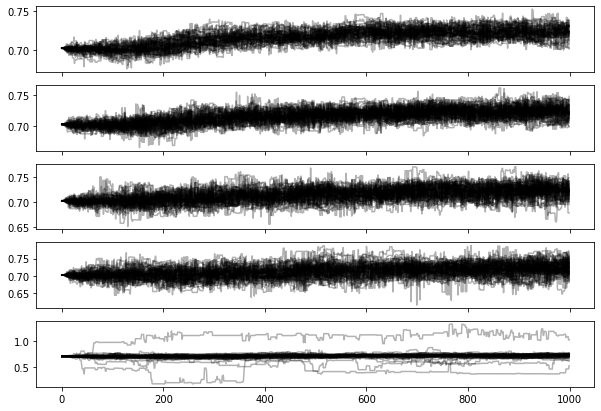

In [363]:
fig, axes = plt.subplots(n_temps, figsize=(10, 7), sharex=True)
samples = np.array([ptsampler.get_chain() for ptsampler in sampler.sampler ])
# logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(n_temps):
    ax = axes[i]
    [ax.plot(samples[i,:, j, 5], "k", alpha=0.3) for j in range(40) ]
    # ax.set_xlim(0, len(samples))
    # ax.axhline(params_best[i], ls="--", color="red")
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


# axes[-1].plot(logprob_sample, "k", alpha=0.3)
# axes[-1].axhline(logl(params_best), ls="--", color="red")
# axes[-1].set_xlabel("step number");     

(640, 20)


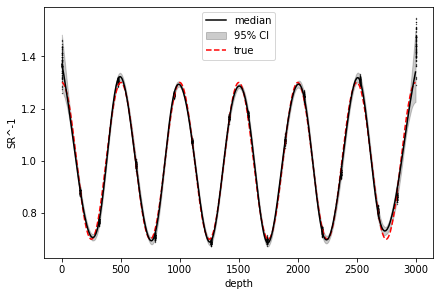

In [328]:
%matplotlib inline
flat_samples = sampler.sampler[0].get_chain(discard=200, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
# invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini):], s=0.1, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

(640, 20)


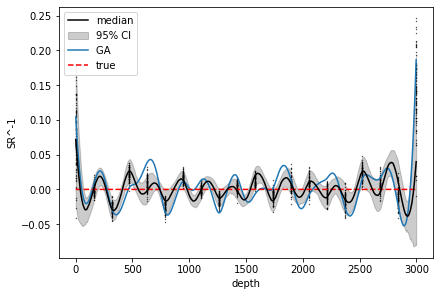

In [341]:
%matplotlib inline
flat_samples = sampler.sampler[0].get_chain(discard=200, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
# invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR-invSR, zorder=10,color="black", label="median")
# plt.plot(depth, mean_invSR-invSR, zorder=10,color="black", label="median")invSR_best
plt.fill_between(depth, invSR_lo-invSR, invSR_up-invSR, alpha=0.2, color="black", label="95% CI")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth)-invSR,label="GA ")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini):]-func_inv_SR(depth_genes), s=0.1, color="black")
# plt.plot(depth_genes, invSR_best-func_inv_SR(depth_genes),'.')
plt.plot(depth, invSR-invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")